In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.model_selection import train_test_split

from convexmtl_torch.model.ConvexTorchCombinator import ConvexTorchCombinator
from convexmtl_torch.model.GraphLaplacianTorchCombinator import GraphLaplacianTorchCombinator
from convexmtl_torch.model.utils import NeuralNetwork

from convexmtl_torch.data.MTLSyntheticDataset import MTLCommonRegression

import torch
from torch.nn import MSELoss
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer

from icecream import ic

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random

from copy import copy


In [2]:
seed = 1

np.random.seed(seed)
random.seed(seed)

In [3]:
log_every_n_steps=10
problem = 'common'

In [4]:
mtlds = MTLCommonRegression(n_samples_per_task=100)

X, y = mtlds.X, mtlds.y

if y.ndim < 2:
    y = y[:, None]

ic| tasks: [0, 1, 2]
ic| colors: {0: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
             1: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
             2: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)}
ic| X_data.shape: (300, 1)


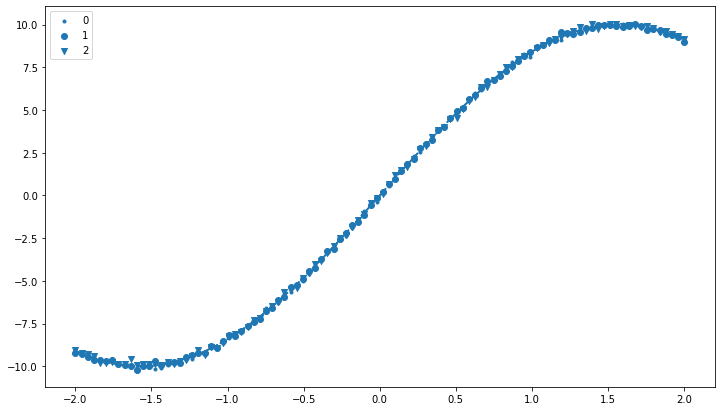

In [5]:
mtlds.plot_data_functions(X, y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_test_numpy = copy(X_test)

In [7]:
X_train, t_train = X_train[:,:-1], X_train[:,-1].astype(int)
X_test, t_test = X_test[:,:-1], X_test[:,-1].astype(int)
X_train, t_train, y_train = map(torch.tensor, (X_train, t_train, y_train))
X_train, t_train, y_train = map(lambda obj: obj.float(), [X_train, t_train, y_train])
X_test, t_test, y_test = map(torch.tensor, (X_test, t_test, y_test))
X_test, t_test, y_test = map(lambda obj: obj.float(), [X_test, t_test, y_test])


In [8]:
tasks = np.unique(t_train)
n_tasks = len(tasks)

In [9]:
# train_ds = TensorDataset(X_train, t_train, y_train)
train_ds = TensorDataset(X_train, t_train, y_train)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)



In [10]:
X_train.shape

torch.Size([201, 1])

## ConvexMTL Torch

In [11]:
max_epochs = 50

In [12]:
model = ConvexTorchCombinator(n_features=1, n_output=1, n_channel=1, tasks=tasks, specific_lambda=False)
model

ConvexTorchCombinator(
  (common_module_): NeuralNetwork(
    (linear_relu_stack): Sequential(
      (0): Linear(in_features=1, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=32, bias=True)
      (5): ReLU()
      (6): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)

In [13]:
trainer = Trainer(max_epochs=max_epochs, log_every_n_steps=log_every_n_steps, default_root_dir='convex_{}_logs'.format(problem))

trainer.fit(model, train_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name           | Type          | Params
-------------------------------------------------
0 | common_module_ | NeuralNetwork | 2.2 K 
-------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)
/home/carlos.ruizp/miniconda3/envs/rkm/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/carlos.ruizp/miniconda3/envs/rkm/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (7) is smaller t

Training: 0it [00:00, ?it/s]

In [14]:
model.tasks

array([0., 1., 2.], dtype=float32)

In [15]:
# pred = model(X_test, t_test)
pred = model(X_test, t_test)

In [16]:
pred_numpy = pred.detach().numpy()
pred_numpy.shape

(99, 1)

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_squared_error(pred_numpy, y_test.detach().numpy())


0.46527508

In [18]:
mean_absolute_error(pred_numpy, y_test.detach().numpy())

0.5404941

In [19]:
model.lambda_lr

0.001

In [20]:
model.common_module_

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

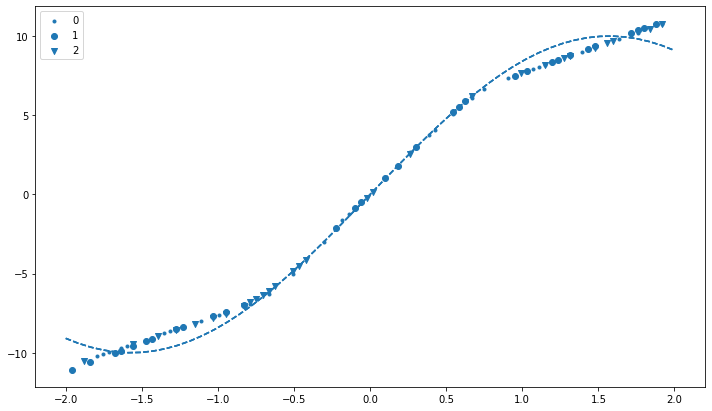

In [21]:
mtlds.plot_data_functions(X_test_numpy, pred_numpy)

In [22]:
model.get_lamb()

array([0.5297073], dtype=float32)

## tensorboard

In [24]:
    %reload_ext tensorboard
    %tensorboard --logdir=gl_common_logs/